# The 2nd level of scenario mining

In [1]:
# imports and global setting

import os
import numpy as np
import json
import time
from rich.progress import track
import pickle
from collections import namedtuple

ROOT = os.path.abspath(os.path.dirname(""))
ROOT = os.path.dirname(ROOT)
DATADIR = os.path.join(ROOT,"waymo_open_dataset","data","tf_example","training")

FILENUM = "00003"

FILE = f"training_tfexample.tfrecord-{FILENUM}-of-01000"
result_dict = {}

# parameter for estimation of the actor approaching a static element
TTC_1 = 5
# parameter for estimation of two actors' interaction
TTC_2 = 10

## Generate static elements and actors trajectories in shapely

In [2]:
# generate lanes
from create_rect_from_file import get_parsed_data,get_agent_list,rect_object_creator
from shapely.geometry import LineString,Polygon,Point,MultiPolygon
from shapely.ops import unary_union
from static_elements import StaticElementsWaymo

decoded_example = get_parsed_data(DATADIR,FILE)
# [num_points, 3] float32.
roadgraph_xyz = decoded_example['roadgraph_samples/xyz'].numpy()
roadgraph_type = decoded_example['roadgraph_samples/type'].numpy()
roadgraph_lane_id = decoded_example['roadgraph_samples/id'].numpy()
roadgraph_dir_xyz = decoded_example['roadgraph_samples/dir'].numpy()

# concatenate past,current and future states of traffic lights
#[num_steps,num_light_positions]
traffic_lights_id = np.concatenate([decoded_example['traffic_light_state/past/id'].numpy(),decoded_example['traffic_light_state/current/id'].numpy(),decoded_example['traffic_light_state/future/id'].numpy()],axis=0)
traffic_lights_valid = np.concatenate([decoded_example['traffic_light_state/past/valid'].numpy(),decoded_example['traffic_light_state/current/valid'].numpy(),decoded_example['traffic_light_state/future/valid'].numpy()],axis=0)
traffic_lights_state = np.concatenate([decoded_example['traffic_light_state/past/state'].numpy(),decoded_example['traffic_light_state/current/state'].numpy(),decoded_example['traffic_light_state/future/state'].numpy()],axis=0)
traffic_lights_pos_x = np.concatenate([decoded_example['traffic_light_state/past/x'].numpy(),decoded_example['traffic_light_state/current/x'].numpy(),decoded_example['traffic_light_state/future/x'].numpy()],axis=0)
traffic_lights_pos_y = np.concatenate([decoded_example['traffic_light_state/past/y'].numpy(),decoded_example['traffic_light_state/current/y'].numpy(),decoded_example['traffic_light_state/future/y'].numpy()],axis=0)

original_data_roadgragh = {
    'roadgraph_xyz':roadgraph_xyz,
    'roadgraph_type':roadgraph_type,
    'roadgraph_dir_xyz':roadgraph_dir_xyz,
    'roadgraph_lane_id':roadgraph_lane_id
}
original_data_light = {
    'traffic_lights_id':traffic_lights_id,
    'traffic_lights_valid':traffic_lights_valid,
    'traffic_lights_state':traffic_lights_state,
    'traffic_lights_pos_x':traffic_lights_pos_x,
    'traffic_lights_pos_y':traffic_lights_pos_y
}
static_element = StaticElementsWaymo(original_data_roadgragh,original_data_light)
static_element.create_polygon_set()
lane_key = ['freeway','surface_street','bike_lane']
other_object_key = ['cross_walk','speed_bump']
controlled_lane = static_element.get_controlled_lane()

## [test codes]

In [3]:
# compute the relation between the actor and the road features

def compute_relation_actor_road_feature(valid_start,valid_end,trajectory_ratio,expanded_ratio):
    """
    -5 ---  invalid
    -1 --- not relative
    0 --- leaving
    1 --- approaching
    2 --- entering
    3 --- staying
    """
    actor_lane_relation = np.ones_like(expanded_ratio)*(-1)
    trajectory_ratio = np.array(trajectory_ratio)
    expanded_ratio = np.array(expanded_ratio)
    interesting_threshold = 1e-2
    # ratio = 0 means not relative

    if np.sum(trajectory_ratio) == 0 and np.sum(expanded_ratio) == 0:
        # making sure the invalid is -5
        actor_lane_relation[:int(valid_start)] = -5
        actor_lane_relation[int(valid_end)+1:] = -5
        return actor_lane_relation.tolist()
    elif np.sum(trajectory_ratio) == 0 and np.sum(expanded_ratio) != 0:
        approaching = np.where(expanded_ratio>interesting_threshold)[0]
        actor_lane_relation[approaching] =1
        # making sure the invalid is -5
        actor_lane_relation[:int(valid_start)] = -5
        actor_lane_relation[int(valid_end)+1:] = -5
        return actor_lane_relation.tolist()
    else:
        # set the actual ratio greater than 1 to 1
        trajectory_ratio = np.where(trajectory_ratio>1,1,trajectory_ratio)
        difference_trajectory_ratio = np.diff(trajectory_ratio)
        relative_time = np.where(trajectory_ratio>interesting_threshold)[0]
        staying = np.intersect1d(np.where(np.abs(difference_trajectory_ratio)<=interesting_threshold)[0]+1,relative_time)
        entering = np.intersect1d(np.where(difference_trajectory_ratio>interesting_threshold)[0]+1,relative_time)
        leaving = np.intersect1d(np.where(difference_trajectory_ratio<-interesting_threshold)[0]+1,relative_time)
        actor_lane_relation[staying] = 3
        actor_lane_relation[entering] = 2
        actor_lane_relation[leaving] = 0
        actor_lane_relation[0] = actor_lane_relation[1]
        actor_lane_relation[valid_start]=actor_lane_relation[valid_start+1]
        # print(difference_trajectory_ratio,difference_trajectory_ratio.shape)
        # print(staying)
        if np.sum(expanded_ratio) != 0:
            approaching = np.where(expanded_ratio>0)[0]
            not_relative = np.where(trajectory_ratio<=interesting_threshold)[0]
            filtered_approaching = np.intersect1d(approaching,not_relative)
            # expanded_ratio > 0 and actor_lane_relation == -1 ==>approaching
            actor_lane_relation[filtered_approaching] =1
        # making sure the invalid is -5
        actor_lane_relation[:int(valid_start)] = -5
        actor_lane_relation[int(valid_end)+1:] = -5
        return actor_lane_relation.tolist()


In [4]:
# expd = actors_static_element_intersection['pedestrian']['pedestrian_70']['cross_walk']['expanded_ratio']
# traj = actors_static_element_intersection['pedestrian']['pedestrian_70']['cross_walk']['trajectory_ratio']
# a = compute_relation_actor_road_feature(valid_start,valid_end,traj,expd)
# print(f"valid:{valid_start},{valid_end}")
# print(a)
# expd[76],traj[76]

## Generate lo/la activity records

In [5]:
from create_rect_from_file import rect_object_creator,get_agent_list
from long_activity_detector import long_act_detector
from data_parser import features_description
from lateral_activity_detector import lat_act_detector

max_acc = [0,0.7,0.2,0.4,0]
a_cruise = [0,0.3,0.1,0.2,0]
delta_v = [0,1,0.2,0.5,0]
actor_dict = {"vehicle":1,"pedestrian":2,"cyclist":3}
agent_state_dict = {"vehicle":{},"pedestrian":{},"cyclist":{}}
agent_pp_state_list = []

k_h=6
time_steps=91
# degree of smoothing spline
k=3
# default smoothing factor is 
smoothing_factor = time_steps / 2

t_s = 0.1
kernel = 6
sampling_threshold = 5e-3
integration_threshold = sampling_threshold*150 # 5e-3*150 = 0.75 rad. = 43 deg.
actors_activity={} # [actor_type][actor_id][validity/lo_act/la_act]
actors_static_element_relation = {} #[actor_type][actor_id][lane_type]
actors_static_element_intersection = {} #[actor_type][actor_id][lane_type][expanded/trajectory],value is a list of area of intersection
actors_list = {} #[actor_type]

# parameter for estimation of the actor approaching a static element
TTC_1 = 5
# parameter for estimation of two actors' interaction
TTC_2 = 9
bbox_extension = 2 # extend length and width of the bbox by 2 times
AgentExtendedPolygons = namedtuple('AgentExtendedPolygons','type,key,etp,ebb,length')
agent_pp_state_list = []

for actor_type in actor_dict:
    agent_type = actor_dict[actor_type]
    agent_list = get_agent_list(agent_type,DATADIR,FILE)
    agent_list_2 = agent_list.copy()
    ############################################## 
    actor_activity = {}
    actor_static_element_intersection = {}
    if len(agent_list.shape) == 0:
        agent_list = [agent_list.item()]
        print(f"Processing {actor_type} with {len(agent_list)} agents...")
    else:
        print(f"Processing {actor_type} with {agent_list.shape[0]} agents...")
    for agent in agent_list:
        agent_activity = {}
        agent_static_element_intersection = {}
        agent_state,_ = rect_object_creator(agent_type,agent,DATADIR,FILE)

        valid_start,valid_end = agent_state.get_validity_range()
        ###########################
        # not computing with only one step valid agent
        if valid_start == valid_end:
            print(agent)
            agent_idx = np.where(agent_list_2==agent)[0]
            agent_list_2 = np.delete(agent_list_2,agent_idx)
            continue

        validity_proportion = agent_state.data_preprocessing()
        agent_key = f"{actor_type}_{agent}"
        # extended trajectory pologons
        _ = agent_state.expanded_polygon_set(TTC=TTC_2,sampling_fq=10)
        etp = agent_state.expanded_multipolygon
        # generate the extended bounding boxes
        ebb = agent_state.expanded_bbox_list(expand=bbox_extension)
        agent_extended_polygons = AgentExtendedPolygons(actor_type,agent_key,etp,ebb,time_steps)
        agent_pp_state_list.append(agent_extended_polygons)
        lo_act,long_v,long_v1,knots = long_act_detector(agent_state,k_h,max_acc[agent_type],t_s=0.1,a_cruise=a_cruise[agent_type],\
                                        delta_v=delta_v[agent_type],time_steps=time_steps,k_cruise=10,\
                                        k=k,smoothing_factor=smoothing_factor)
        long_v = long_v.squeeze()
        lo_act = lo_act.squeeze()
        agent_activity['validity/appearance'] = validity_proportion
        agent_activity['lo_act'] = lo_act.tolist()
        la_act,bbox_yaw_rate = lat_act_detector(agent_state,t_s,sampling_threshold,integration_threshold,k=3,smoothing_factor=smoothing_factor)
        agent_activity['la_act'] = la_act.squeeze().tolist()
        ###############################################
        agent_activity['valid'] = np.array([valid_start,valid_end],dtype=np.float32).tolist()
        actor_activity[f"{agent_key}_activity"] = agent_activity
        agent_state_dict[actor_type][agent_key] = agent_state
        # Generate actors in shapely
        actor_expanded_polygon = agent_state.expanded_polygon_set(TTC=TTC_1,sampling_fq=10)
        actor_expanded_multipolygon = actor_expanded_polygon
        actor_trajectory_polygon = agent_state.polygon_set()
        # compute intersection with all lane types
        for lane_type in lane_key:
            agent_lane_intersection_expanded = np.zeros_like(lo_act).tolist()
            agent_lane_intersection_expanded_ratio = np.zeros_like(lo_act).tolist()
            agent_lane_intersection_trajectory = np.zeros_like(lo_act).tolist()
            agent_lane_intersection_trajectory_ratio = np.zeros_like(lo_act).tolist()
            lane_polygon_list = static_element.get_lane(lane_type)
            for step in range(valid_start,valid_end+1):
                actor_expanded_multipolygon_step = actor_expanded_multipolygon[step]
                actor_trajectory_polygon_step = actor_trajectory_polygon[step]
                intersection,intersection_expanded = 0,0
                # intersection = unary_union(lane_polygon_list).intersection(actor_trajectory_polygon_step).area
                # intersection_expanded = unary_union(lane_polygon_list).intersection(actor_expanded_multipolygon_step).area
                for lane_polygon in lane_polygon_list:
                    intersection_expanded += actor_expanded_multipolygon_step.intersection(lane_polygon).area
                    intersection += actor_trajectory_polygon_step.intersection(lane_polygon).area
                agent_lane_intersection_expanded[step]=intersection_expanded
                agent_lane_intersection_trajectory[step]=intersection
                agent_lane_intersection_expanded_ratio[step] = intersection_expanded/actor_expanded_multipolygon_step.area
                agent_lane_intersection_trajectory_ratio[step] = intersection/actor_trajectory_polygon_step.area
            agent_lane_relation = compute_relation_actor_road_feature(valid_start,valid_end,agent_lane_intersection_trajectory_ratio,agent_lane_intersection_expanded_ratio)
            agent_static_element_intersection[lane_type]={
                'relation':agent_lane_relation,
                'expanded':agent_lane_intersection_expanded,
                'expanded_ratio':agent_lane_intersection_expanded_ratio,
                'trajectory':agent_lane_intersection_trajectory,
                'trajectory_ratio':agent_lane_intersection_trajectory_ratio
            }
        # compute intersection with other types of objects
        for other_object_type in other_object_key:
            agent_other_object_intersection_expanded = np.zeros_like(lo_act).tolist()
            agent_other_object_intersection_trajectory = np.zeros_like(lo_act).tolist()
            agent_other_object_intersection_expanded_ratio = np.zeros_like(lo_act).tolist()
            agent_other_object_intersection_trajectory_ratio = np.zeros_like(lo_act).tolist()
            other_object_polygon_list = static_element.get_other_object(other_object_type)
            for step in range(valid_start,valid_end+1):
                actor_expanded_multipolygon_step = actor_expanded_multipolygon[step]
                actor_trajectory_polygon_step = actor_trajectory_polygon[step]
                intersection,intersection_expanded = 0,0

                # intersection = unary_union(other_object_polygon_list).intersection(actor_trajectory_polygon_step).area
                # intersection_expanded = unary_union(other_object_polygon_list).intersection(actor_expanded_multipolygon_step).area
                
                for other_object_polygon in other_object_polygon_list:
                    intersection_expanded += actor_expanded_multipolygon_step.intersection(other_object_polygon).area
                    intersection += actor_trajectory_polygon_step.intersection(other_object_polygon).area
                    
                agent_other_object_intersection_expanded[step]=intersection_expanded
                agent_other_object_intersection_trajectory[step]=intersection
                agent_other_object_intersection_expanded_ratio[step] = intersection_expanded/actor_expanded_multipolygon_step.area
                agent_other_object_intersection_trajectory_ratio[step] = intersection/actor_trajectory_polygon_step.area
            agent_lane_relation = compute_relation_actor_road_feature(valid_start,valid_end,agent_other_object_intersection_trajectory_ratio,agent_other_object_intersection_expanded_ratio)
            agent_static_element_intersection[other_object_type]={
                'relation':agent_lane_relation,
                'expanded':agent_other_object_intersection_expanded,
                'expanded_ratio':agent_other_object_intersection_expanded_ratio,
                'trajectory':agent_other_object_intersection_trajectory,
                'trajectory_ratio':agent_other_object_intersection_trajectory_ratio
            }
        # compute intersection with controlled lanes
        controlled_lanes = static_element.get_controlled_lane()
        controlled_lanes_id = static_element.controlled_lanes_id
        traffic_lights_state = static_element.traffic_lights['traffic_lights_state']
        traffic_lights_id = static_element.traffic_lights['traffic_lights_lane_id']
        traffic_lights_points= static_element.traffic_lights['points']

        for controlled_lane,controlled_lane_id in zip(controlled_lanes,controlled_lanes_id):
            agent_controlled_lane_intersection_expanded = np.zeros_like(lo_act).tolist()
            agent_controlled_lane_intersection_trajectory = np.zeros_like(lo_act).tolist()
            agent_controlled_lane_intersection_expanded_ratio = np.zeros_like(lo_act).tolist()
            agent_controlled_lane_intersection_trajectory_ratio = np.zeros_like(lo_act).tolist()
            intersection,intersection_expanded = [],[]
            intersection_ratio,intersection_expanded_ratio = [],[]
            intersected_polygons,intersected_polygons_expanded = [],[]
            for step in range(valid_start,valid_end+1):
                actor_expanded_multipolygon_step = actor_expanded_multipolygon[step]
                actor_trajectory_polygon_step = actor_trajectory_polygon[step]
                agent_controlled_lane_intersection_expanded[step]=actor_expanded_multipolygon_step.intersection(controlled_lane).area
                agent_controlled_lane_intersection_trajectory[step]=actor_trajectory_polygon_step.intersection(controlled_lane).area
                agent_controlled_lane_intersection_expanded_ratio[step] = actor_expanded_multipolygon_step.intersection(controlled_lane).area/actor_expanded_multipolygon_step.area
                agent_controlled_lane_intersection_trajectory_ratio[step] = actor_trajectory_polygon_step.intersection(controlled_lane).area/actor_trajectory_polygon_step.area
                intersected_polygons.append(actor_expanded_multipolygon_step.intersection(controlled_lane))
                intersected_polygons_expanded.append(actor_expanded_multipolygon_step.intersection(controlled_lane))
            actor_lane_relation = compute_relation_actor_road_feature(valid_start,valid_end,agent_controlled_lane_intersection_trajectory_ratio,agent_controlled_lane_intersection_expanded_ratio)
            if np.sum(agent_controlled_lane_intersection_expanded)==0 and np.sum(agent_controlled_lane_intersection_trajectory)==0:
                flag_controlled_lane = False
                continue
            else:
                intersected_polygon = unary_union(intersected_polygons)
                intersected_polygon_expanded = unary_union(intersected_polygons_expanded)
                light_index = 0
                for light_index_temp,traffic_light_point in enumerate(traffic_lights_points):
                    if np.sum(agent_controlled_lane_intersection_trajectory)>0 and intersected_polygon.contains(traffic_light_point):
                        light_index = light_index_temp
                        break
                    elif np.sum(agent_controlled_lane_intersection_expanded)>0 and intersected_polygon_expanded.contains(traffic_light_point):
                        light_index = light_index_temp
                        break
                light_state = traffic_lights_state[:,light_index].tolist()
                controlled_lane_key = f"controlled_lane_{controlled_lane_id}"
                agent_static_element_intersection[controlled_lane_key]={
                    'relation':actor_lane_relation,
                    'light_state':light_state,
                    'expanded':agent_controlled_lane_intersection_expanded,
                    'expanded_ratio':agent_controlled_lane_intersection_expanded_ratio,
                    'trajectory':agent_controlled_lane_intersection_trajectory,
                    'trajectory_ratio':agent_controlled_lane_intersection_trajectory_ratio
                }
        actor_static_element_intersection[agent_key] = agent_static_element_intersection
        road_graph_plot_flag=0
    actors_list[actor_type] = agent_list_2.tolist()
    actors_activity[actor_type] = actor_activity
    actors_static_element_intersection[actor_type] = actor_static_element_intersection


Processing vehicle with 52 agents...
Processing pedestrian with 6 agents...
57
Processing cyclist with 0 agents...


In [8]:
agent_pp_state_list[2].etp
type(agent_pp_state_list[2].etp[89])

list

## Generate inter-actor relations

In [9]:
from itertools import count
from rich.progress import track

inter_actor_relation = {}
count = 0

"""
0 --- not related
1 --- related by extended trajectory polygons   (etp or type 1)
2 --- related by extended bounding boxes    (ebb or type 2)
3 --- related by both etp and ebb (type 3)
"""

for agent_pp_state_1 in agent_pp_state_list:
    agent_key_1 = agent_pp_state_1.key
    agent_type_1 = agent_pp_state_1.type
    agent_etp_1 = agent_pp_state_1.etp
    agent_ebb_1 = agent_pp_state_1.ebb
    length = agent_pp_state_1.length
    inter_actor_relation[agent_key_1] = {}
    for temp,agent_pp_state_2 in enumerate(agent_pp_state_list):
        if agent_pp_state_2.key == agent_key_1:
            continue
        else:
            agent_key_2 = agent_pp_state_2.key
        agent_type_2 = agent_pp_state_2.type
        agent_etp_2 = agent_pp_state_2.etp
        agent_ebb_2 = agent_pp_state_2.ebb
        relation = np.zeros(length)
        for step in range(length):
            # print(len(agent_etp_1[step]))
            # print(len(agent_etp_2[step]))
            # print(step)
            if agent_etp_1[step][0].area == 0 or agent_etp_2[step][0].area == 0:
                continue
            else:
                etp_flag = 0
                for i,(polygon_1,polygon_2) in enumerate(zip(agent_etp_1[step],agent_etp_2[step])):
                    intersection_etp = polygon_1.intersection(agent_etp_2[step][i]).area
                    if intersection_etp:
                        etp_flag = 1
                        break
                intersection_ebb = agent_ebb_1[step].intersection(agent_ebb_2[step]).area
                if etp_flag and intersection_ebb:
                    relation[step] = 3
                elif etp_flag and not intersection_ebb:
                    relation[step] = 1
                elif not etp_flag and intersection_ebb:
                    relation[step] = 2

                # intersection_etp = agent_etp_1[step].buffer(0.05).intersection(agent_etp_2[step].buffer(0.05)).area
                # intersection_ebb = agent_ebb_1[step].intersection(agent_ebb_2[step]).area
                # if intersection_etp and intersection_ebb:
                #     relation[step] = 3
                # elif intersection_etp and not intersection_ebb:
                #     relation[step] = 1
                # elif not intersection_etp and intersection_ebb:
                #     relation[step] = 2
        if np.sum(relation):
            count+=1
            inter_actor_relation[agent_key_1][agent_key_2] = relation.tolist()
print(count)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
1
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


KeyboardInterrupt: 

In [19]:
# record file

RESULTDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"results\v3")
RESULT_TIME = time.strftime("%Y-%m-%d-%H_%M",time.localtime())
RESULT_FILENAME = f'Waymo_{FILENUM}_{RESULT_TIME}.json'

result_dict = {
    'actors_list':actors_list,
    'inter_actor_relation':inter_actor_relation,
    'actors_activity':actors_activity,
    'actors_static_element_intersection':actors_static_element_intersection
}

with open(os.path.join(RESULTDIR,RESULT_FILENAME),'w') as f:
    json.dump(result_dict,f)

with open(os.path.join(RESULTDIR,RESULT_FILENAME.replace('.json','.pkl')),'wb') as f:
    pickle.dump(result_dict,f)

## Generate one-actor scenarios
- valid period
- longitudinal activities
- lateral activities
- road relations
- inter-actor relation
- plot 1: trajectory, extended trajectory 1, and road graph
- plot 2: trajectory, extended trajectory 2(type 1 and type 2), and related actor (extended) trajectory and road graph

In [3]:
from tags_dict import lo_act_dict,la_act_dict,road_relation_dict,inter_actor_dict,light_state_dict
from collections import Iterable

RESULTDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"results\v3")

RESULT_TIME = f'2022-11-03-12_06'
RESULT_FILENAME = f'Waymo_{FILENUM}_{RESULT_TIME}.json'
RESULT_DICT = actors_static_element_intersection = json.load(open(os.path.join(RESULTDIR,RESULT_FILENAME),'r'))

actors_list = RESULT_DICT['actors_list']
inter_actor_relation = RESULT_DICT['inter_actor_relation']
actors_activity = RESULT_DICT['actors_activity']
actors_static_element_intersection = RESULT_DICT['actors_static_element_intersection']
solo_scenarios = {}
band_scenarios = {}

def computing_turning_point(activity,valid_start:int,valid_end:int)->list:
    """
    find turning points of activity.
    i.e. the start of another type of activity
    """
    turning_points = [valid_start]
    for i in range(valid_start+1,valid_end):
        if activity[i] != activity[i-1]:
            turning_points.append(i)
    return turning_points

def summarizing_events(activity,turning_points:list,valid_start:int,valid_end:int,event_type:str,activity_type:dict)->dict:
    """
    summarize events from activity and turning points
    event_type: [lo, la]
    format:
    key:{event_type}_{number}
    value:{activity_type,start_frame,end_frame}
    """
    events_summary = {}
    for i,turning_point in enumerate(turning_points):
        event = activity_type[str(int(activity[turning_point]))]
        events_summary[f'{event_type}_{i}'] = {
            'event':event,
            'start':turning_point,
            'end':turning_points[i+1] if i+1<len(turning_points) else valid_end
        }
    return events_summary

for (actor_type,actors) in actors_list.items():
    if not isinstance(actors,Iterable):
        actors = [actors]
    solo_scenarios[actor_type] = {}
    for agent in actors:
        agent_key = f"{actor_type}_{agent}"
        solo_scenarios[actor_type][agent_key]={}
        # longitudinal and lateral activity
        agent_activity = actors_activity[actor_type][f"{agent_key}_activity"]
        (valid_start,valid_end) = agent_activity['valid']
        valid_start = int(valid_start)
        valid_end = int(valid_end)
        agent_lo_act = agent_activity['lo_act']
        turning_points = computing_turning_point(agent_lo_act,valid_start,valid_end)
        solo_scenarios[actor_type][agent_key]['lo']=summarizing_events(agent_lo_act,turning_points,valid_start,valid_end,'lo',lo_act_dict)        
        agent_la_act = agent_activity['la_act']
        turning_points = computing_turning_point(agent_la_act,int(valid_start),int(valid_end))
        solo_scenarios[actor_type][agent_key]['la']=summarizing_events(agent_la_act,turning_points,valid_start,valid_end,'la',la_act_dict)
        # agent and static element relation
        agent_elements_relation = actors_static_element_intersection[actor_type][agent_key]
        solo_scenarios[actor_type][agent_key]['static'] = {}
        for (element_type,element) in agent_elements_relation.items():
            relation = element['relation']
            if sum(relation[valid_start:valid_end+1])== -(valid_end-valid_start+1):
                continue
            else:
                turning_points = computing_turning_point(relation,valid_start,valid_end)
                solo_scenarios[actor_type][agent_key]['static'][element_type] = summarizing_events(relation,turning_points,valid_start,valid_end,element_type,road_relation_dict)
                if element_type.startswith("controlled_lane"):
                    turning_points = computing_turning_point(element['light_state'],valid_start,valid_end)
                    solo_scenarios[actor_type][agent_key]['static'][element_type]['light_state'] = summarizing_events(element['light_state'],turning_points,valid_start,valid_end,'light',light_state_dict)
        # inter-actor relation
        inter_actor = inter_actor_relation[agent_key]
        solo_scenarios[actor_type][agent_key]['inter_actor'] = {}
        for (actor_name,relation) in inter_actor.items():
            turning_points = computing_turning_point(relation,valid_start,valid_end)
            solo_scenarios[actor_type][agent_key]['inter_actor'][actor_name] = summarizing_events(relation,turning_points,valid_start,valid_end,actor_name,inter_actor_dict)

In [4]:
# record file

RESULTDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"results\v3")
RESULT_FILENAME = f'Waymo_{FILENUM}_solo_{RESULT_TIME}.json'

result_dict = solo_scenarios

with open(os.path.join(RESULTDIR,RESULT_FILENAME),'w') as f:
    json.dump(result_dict,f)

with open(os.path.join(RESULTDIR,RESULT_FILENAME.replace('.json','.pkl')),'wb') as f:
    pickle.dump(result_dict,f)

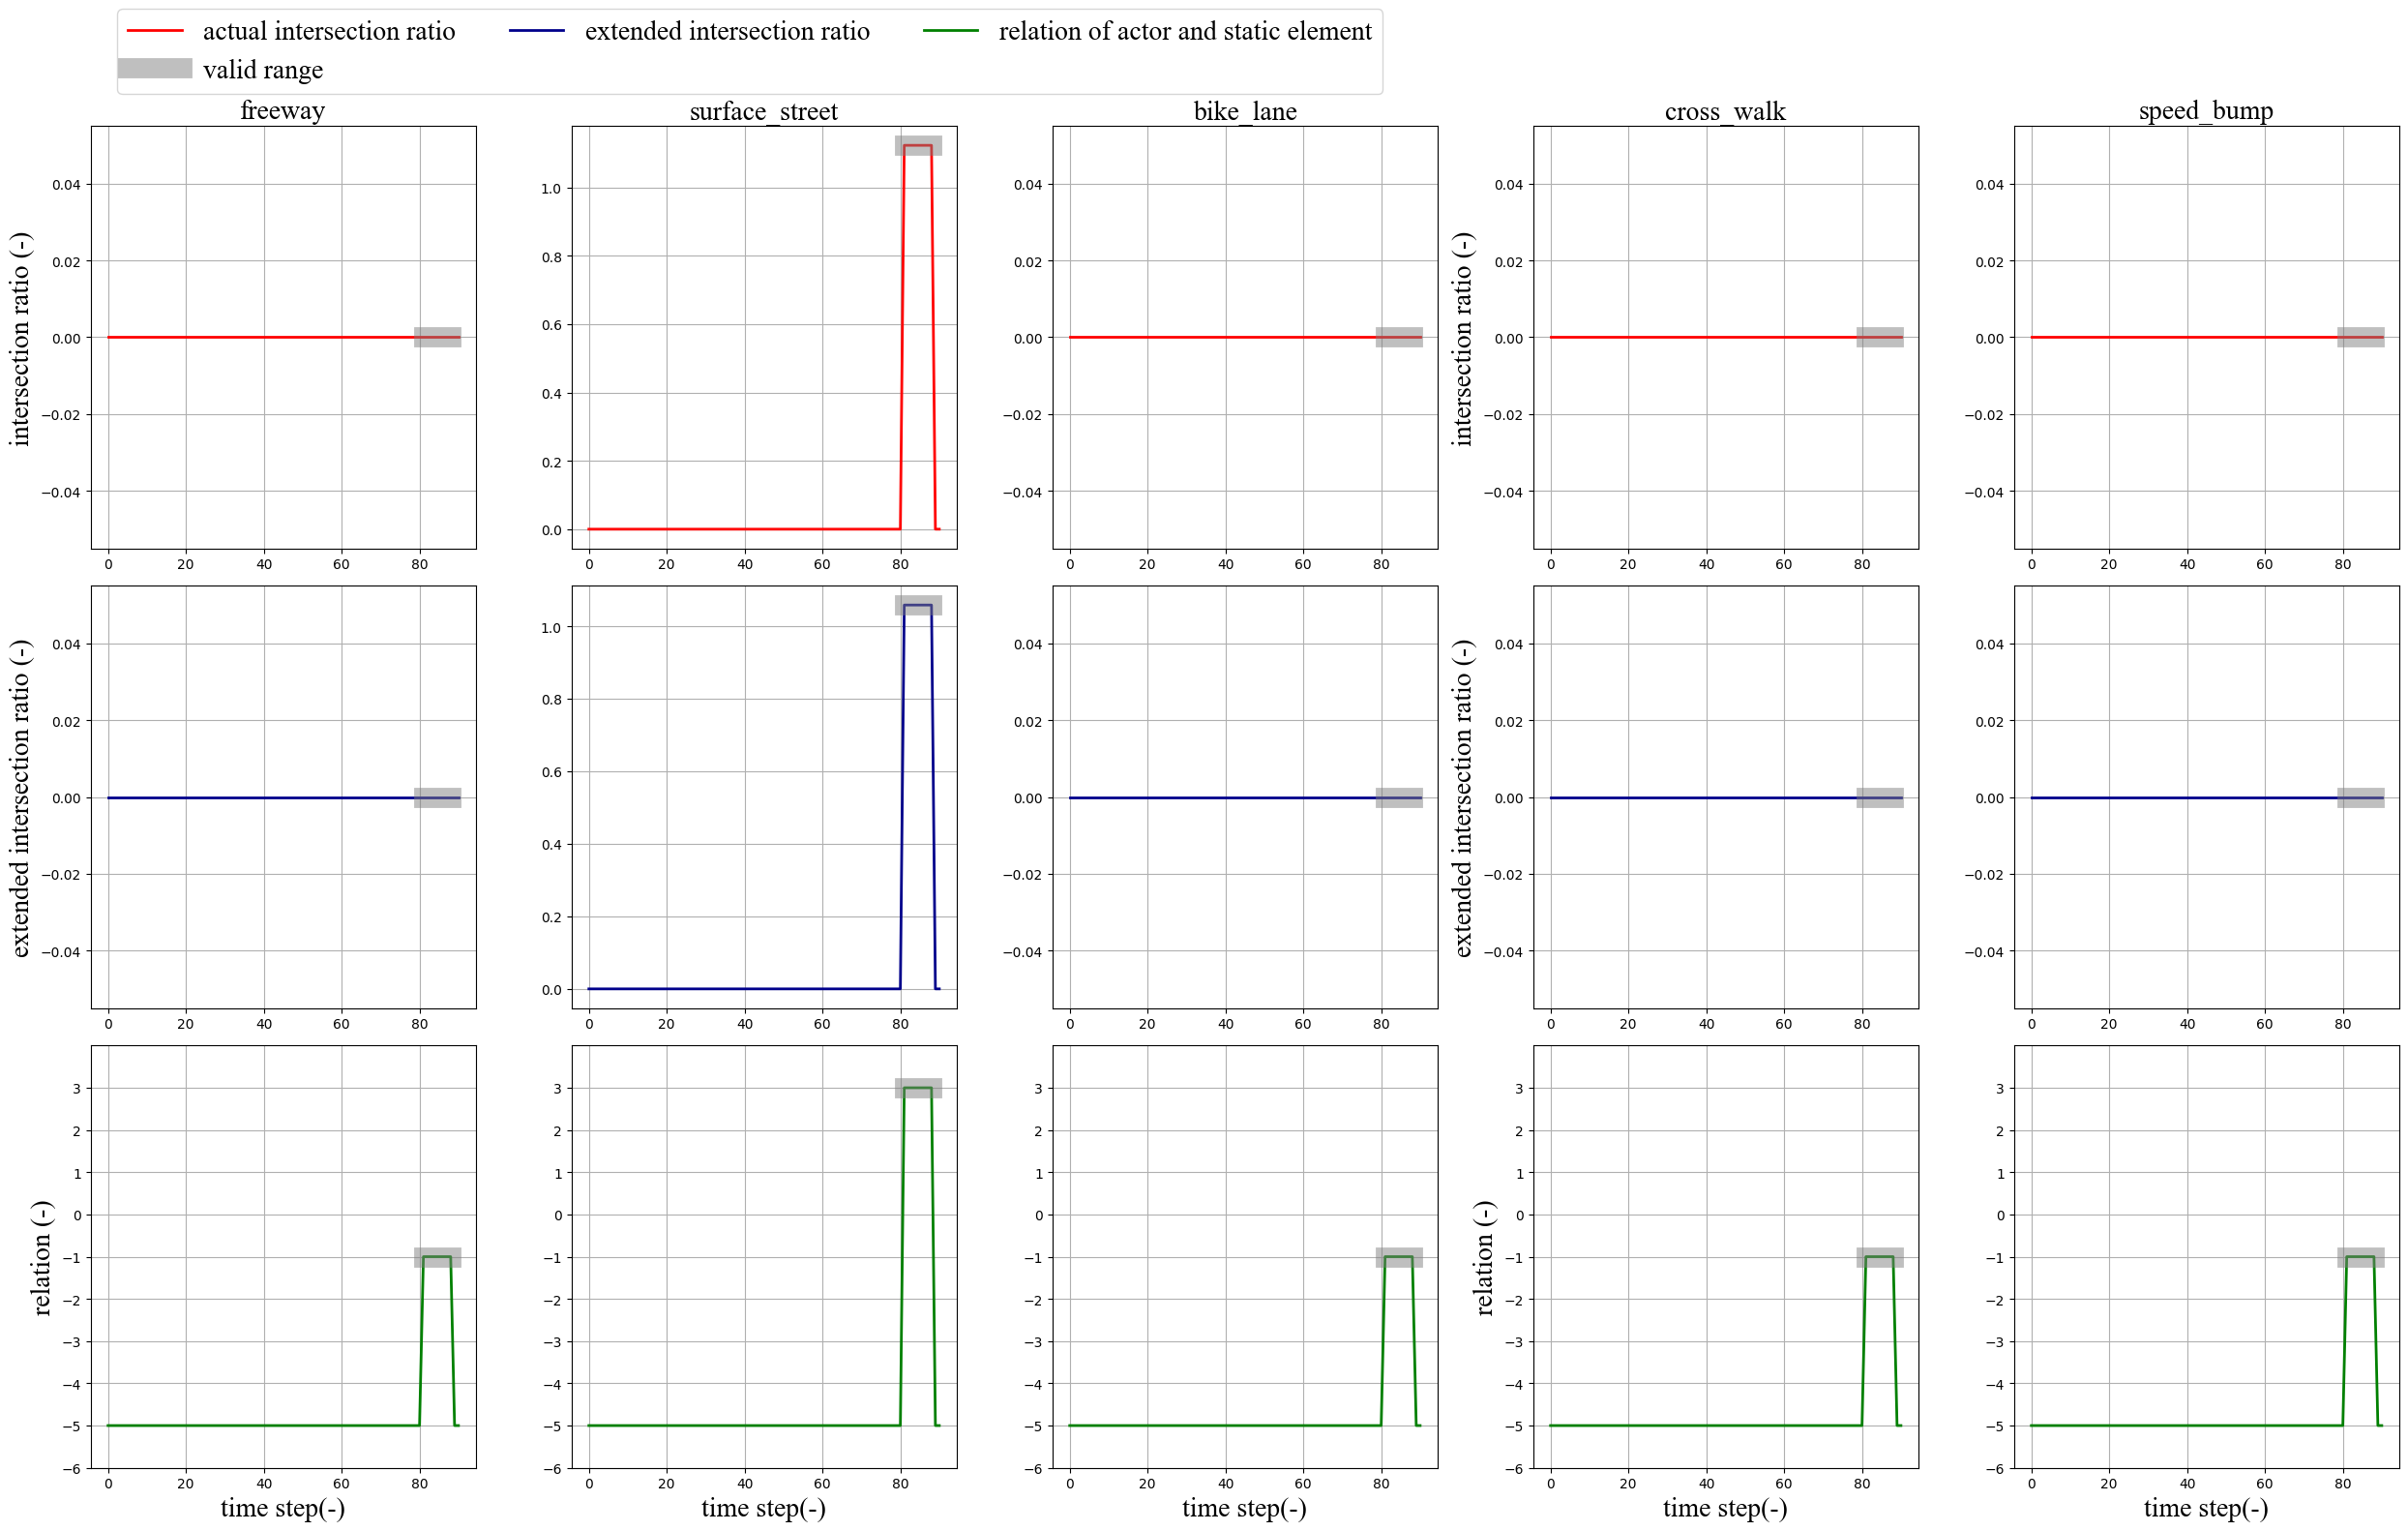

In [49]:
## plot intersection
import matplotlib.pyplot as plt
import json
from collections import OrderedDict

font1 = {'family' : 'Times New Roman','weight' : 'normal','size':20}

actor_type = 'vehicle'
actor_key_plot = 'vehicle_101'
actor_key_activity = f"{actor_key_plot}_activity"

RESULTDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"results\v2")
RESULT_TIME = f'2022-10-28-11_52'
RESULT_FILENAME = f'Waymo_{FILENUM}_{RESULT_TIME}.json'

actors_static_element_intersection = json.load(open(os.path.join(RESULTDIR,RESULT_FILENAME),'r'))['actors_static_element_intersection']
(valid_start,valid_end) = json.load(open(os.path.join(RESULTDIR,RESULT_FILENAME),'r'))['actors_activity'][actor_type][actor_key_activity]['valid']
valid_start = int(valid_start)
valid_end = int(valid_end)

nrow = 3
ncol = len(actors_static_element_intersection[actor_type][actor_key_plot].keys())
fig,axes = plt.subplots(nrow,ncol,figsize=(5*ncol,5*nrow))
ax_list = axes.flatten()
plot_lane_key = list(actors_static_element_intersection[actor_type][actor_key_plot].keys())
plot_polygon_key = ['expanded','trajectory']

lines_legend,labels_legend = [],[]
for i in range(ncol):
    ax_list[i].set_title(plot_lane_key[i],fontdict=font1)
    y = actors_static_element_intersection[actor_type][actor_key_plot][plot_lane_key[i]]['trajectory_ratio']
    x = np.arange(len(y))
    ax_list[i].plot(x,y,c='r',label='actual intersection ratio',linewidth=2)
    ax_list[i].plot(x[valid_start:valid_end+1],y[valid_start:valid_end+1],c='gray',linewidth=15,alpha=0.5,label='valid range')
    ax_list[i].grid()
    ax_line_legend,ax_label_legend = ax_list[i].get_legend_handles_labels()
    lines_legend.extend(ax_line_legend)
    labels_legend.extend(ax_label_legend)
    # ax_list[i].legend(loc="upper right",prop=font1)
    if i == 0 or i==3:
        ax_list[i].set_ylabel('intersection ratio (-)',fontdict=font1)
        ax_list[i+ncol].set_ylabel('extended intersection ratio (-)',fontdict=font1)
        ax_list[i+2*ncol].set_ylabel('relation (-)',fontdict=font1)

    y = actors_static_element_intersection[actor_type][actor_key_plot][plot_lane_key[i]]['expanded_ratio']
    x = np.arange(len(y))
    ax_list[i+ncol].plot(x,y,c='darkblue',label='extended intersection ratio',linewidth=2)
    ax_list[i+ncol].plot(x[valid_start:valid_end+1],y[valid_start:valid_end+1],c='gray',linewidth=15,alpha=0.5,label='valid range')
    ax_list[i+ncol].grid()
    ax_line_legend,ax_label_legend = ax_list[i+ncol].get_legend_handles_labels()
    lines_legend.extend(ax_line_legend)
    labels_legend.extend(ax_label_legend)
    # ax_list[i+5].legend(loc="upper right",prop=font1)

    y = actors_static_element_intersection[actor_type][actor_key_plot][plot_lane_key[i]]['relation']
    x = np.arange(len(y))
    ax_list[i+2*ncol].plot(x,y,c='green',label='relation of actor and static element',linewidth=2)
    ax_list[i+2*ncol].plot(x[valid_start:valid_end+1],y[valid_start:valid_end+1],c='gray',linewidth=15,alpha=0.5,label='valid range')
    ax_list[i+2*ncol].grid()
    ax_list[i+2*ncol].set_ylim(-6,4)
    ax_list[i+2*ncol].yaxis.set_ticks(np.arange(-6,4,1))
    ax_line_legend,ax_label_legend = ax_list[i+2*ncol].get_legend_handles_labels()
    lines_legend.extend(ax_line_legend)
    labels_legend.extend(ax_label_legend)
    ax_list[i+2*ncol].set_xlabel('time step(-)',fontdict=font1)

axbox = ax_list[1].get_position()
by_label = OrderedDict(zip(labels_legend,lines_legend))
fig.legend(by_label.values(),by_label.keys(),loc='upper center',prop=font1,ncol=3,
           bbox_to_anchor=(axbox.x0+0.2*axbox.width,axbox.y0+1.8*axbox.height))

FIGDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"figures\relation_actor_lane\v3")
plt.tight_layout()
plt.savefig(f"{FIGDIR}\{FILENUM}_{actor_key_plot}_intersection.jpg",bbox_inches='tight')
plt.show()

## Generate visualizations for one actor scenarios

## relate actors with static element

In [28]:
"""
-5 ---  invalid
-1 --- not relative
0 --- leaving
1 --- approaching
2 --- entering
3 --- staying
"""
import pandas as pd
import pickle

RESULTDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"results\v2")
RESULT_TIME = f'2022-10-24-15_05'
RESULT_FILENAME = f'Waymo_{FILENUM}_{RESULT_TIME}.json'

actors_static_element_intersection = json.load(open(os.path.join(RESULTDIR,RESULT_FILENAME),'r'))['actors_static_element_intersection']
actors_activity = json.load(open(os.path.join(RESULTDIR,RESULT_FILENAME),'r'))['actors_activity']

actors_static_element_relation = {}

for actor_type in actors_static_element_intersection:
    actor_static_element_relation = {}
    actor_static_element_intersection = actors_static_element_intersection[actor_type]
    for actor_key in actor_static_element_intersection:
        actor_all_lane_relation = {}
        actor_key_activity = f"{actor_key}_activity"
        (valid_start,valid_end) = actors_activity[actor_type][actor_key_activity]['valid']
        actor_lanes_intersection = actor_static_element_intersection[actor_key]
        for lane_type in actor_lanes_intersection:
            if lane_type == "controlled_lane":
                continue
            expanded_ratio = np.array(actor_lanes_intersection[lane_type]['expanded_ratio'])
            trajectory_ratio = np.array(actor_lanes_intersection[lane_type]['trajectory_ratio'])
            actor_lane_relation = np.ones_like(expanded_ratio)*(-1)
            # ratio = 0 means not relative
            # print(lane_type)
            if np.sum(trajectory_ratio) == 0 and np.sum(expanded_ratio) == 0:
                # making sure the invalid is -5
                actor_lane_relation[:int(valid_start)] = -5
                actor_lane_relation[int(valid_end)+1:] = -5
                actor_all_lane_relation[lane_type] = actor_lane_relation.tolist()
                continue 
            elif np.sum(trajectory_ratio) == 0 and np.sum(expanded_ratio) != 0:
                approaching = np.where(expanded_ratio>1e-2)[0]
                actor_lane_relation[approaching] =1
                # making sure the invalid is -5
                actor_lane_relation[:int(valid_start)] = -5
                actor_lane_relation[int(valid_end)+1:] = -5
                actor_all_lane_relation[lane_type] = actor_lane_relation.tolist()
                continue
            else:
                # set the actual ratio greater than 1 to 1
                trajectory_ratio = np.where(trajectory_ratio>1,1,trajectory_ratio)
                difference_trajectory_ratio = np.diff(trajectory_ratio)
                relative_time = np.where(trajectory_ratio>0)[0]
                staying = np.intersect1d(np.where(np.abs(difference_trajectory_ratio)<1e-2)[0],relative_time)
                entering = np.intersect1d(np.where(difference_trajectory_ratio>1e-2)[0],relative_time)
                leaving = np.intersect1d(np.where(difference_trajectory_ratio<-1e-2)[0],relative_time)
                actor_lane_relation[staying+1] = 3
                actor_lane_relation[entering+1] = 2
                actor_lane_relation[leaving+1] = 0
                actor_lane_relation[0] = actor_lane_relation[1]
                if np.sum(expanded_ratio) == 0:
                    continue
                else:
                    approaching = np.where(expanded_ratio>0)[0]
                    # print(f"approaching:{approaching},entering_start:{entering_start},leaving_end:{leaving_end}")
                    not_relative = np.where(actor_all_lane_relation==-1)[0]
                    print(approaching)
                    print(not_relative)
                    filtered_approaching = np.intersect1d(approaching,not_relative)
                    print(f"filtered_approaching:{filtered_approaching}")
                    actor_lane_relation[filtered_approaching] =1
            # making sure the invalid is -5
            actor_lane_relation[:int(valid_start)] = -5
            actor_lane_relation[int(valid_end)+1:] = -5
            actor_all_lane_relation[lane_type] = actor_lane_relation.tolist()
            
        actor_static_element_relation[actor_key] = actor_all_lane_relation
    actors_static_element_relation[actor_type] = actor_static_element_relation

result_dict = actors_static_element_relation
RESULT_TIME = time.strftime("%Y-%m-%d-%H_%M",time.localtime())
RESULT_FILENAME = f'Waymo_{FILENUM}_{RESULT_TIME}.json'
with open(os.path.join(RESULTDIR,RESULT_FILENAME),'w') as f:
    json.dump(result_dict,f)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
[]
filtered_approaching:[]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
[]
filtered_approaching:[]
[27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
[]
filtered_approaching:[]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54

## [test codes]

In [54]:
from tags_dict import lo_act_dict,la_act_dict
new_dict = {"la":la_act_dict,"lo":lo_act_dict}
for key,value in new_dict:
    print(key,value)

l a
l o


In [2]:
import numpy as np
a = np.array([])
type(a) is np.ndarray
len(a)

0

In [69]:
# runtime test
import time
import numpy as np

def turning_point1(activity,valid_start:int,valid_end:int)->list:
    """
    find turning points of activity
    """
    turning_points = []
    for i in range(valid_start+1,valid_end):
        if activity[i] != activity[i-1]:
            turning_points.append(i)
    return turning_points

def turning_point2(activity,valid_start:int,valid_end:int)->list:
    """
    find turning points of activity
    """
    new_act = np.insert(np.diff(activity),0,0)
    return np.where(new_act!=0)[0]

activity = [-1.0,-1.0,-2.0,-2.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0]
turningpoint1,turningpoint2 = [],[]
measure_start = time.perf_counter()
for i in range(100):
    turningpoint1=turning_point1(activity,0,len(activity)-1)
measure_end = time.perf_counter()
print(f"turning_point1:{measure_end-measure_start}")
measure_start = time.perf_counter()
for i in range(100):
    turningpoint2=turning_point2(activity,0,len(activity)-1)
measure_end = time.perf_counter()
print(f"turning_point2:{measure_end-measure_start}")

turning_point1:0.00016139999934239313
turning_point2:0.0028455000028770883


In [10]:
# import numpy as np
# a = np.array([1,2,3,4,1,1,7,8,1,10])
# for i in range(len(a)):
#     if a[i] == np.nan:
#         print(i)
# print(a)
# filtered_a = np.bitwise_or(a<3,a>8)
# a[filtered_a]
# b=np.diff(a)
# print(b)
# a[np.intersect1d(a,b)]

# c = np.array([1,2,3,4,5,6,7,8,9,10])
# c = np.resize(c,(2,5))
# print(c)
# np.where(c<7)

from cProfile import label
from shapely.geometry import Polygon,LineString,Point
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# 4 * rectangular (width=2, length=10)
a = Polygon([(0,-1),(10,-1),(10,1),(0,1)])
b = Polygon([(0,9),(10,9),(10,11),(0,11)])
c = Polygon([(-1,0),(1,0),(1,10),(-1,10)])
d = Polygon([(9,0),(11,0),(11,10),(9,10)])
united_polygon = [a,b,c,d]
print(f"Area of each one:{a.area},{b.area},{c.area},{d.area}")
print(f"Area of the union:{unary_union(united_polygon).area}")

Area of each one:20.0,20.0,20.0,20.0
Area of the union:76.0


#### Dict is faster than array for getting pairs.

In [34]:
import numpy as np
import time
road_relation_array = np.array([[3,"staying"],[2,"entering"],[1,"approaching"],[0,"leaving"],[-1,"not relative"],[-5,"invalid"]])

road_relation_dict = {
"3":'staying',
"2":'entering',
"1":'approaching',
"0":'leaving',
"-1":'not relative',
"-5":'invalid'
}
x_step = str("3")
time_start = time.perf_counter()
for i in range(1000):
    x_step = str("3")
    result = road_relation_dict[x_step]
time_end = time.perf_counter()
print(f"Dict method:{time_end-time_start}")


time_start = time.perf_counter()
for i in range(1000):
    result=road_relation_array[np.where(road_relation_array[:,0]==str(3))[0],1]
time_end = time.perf_counter()
print(f"Array method:{time_end-time_start}")

Dict method:0.00022119999994174577
Array method:0.007055799999761803


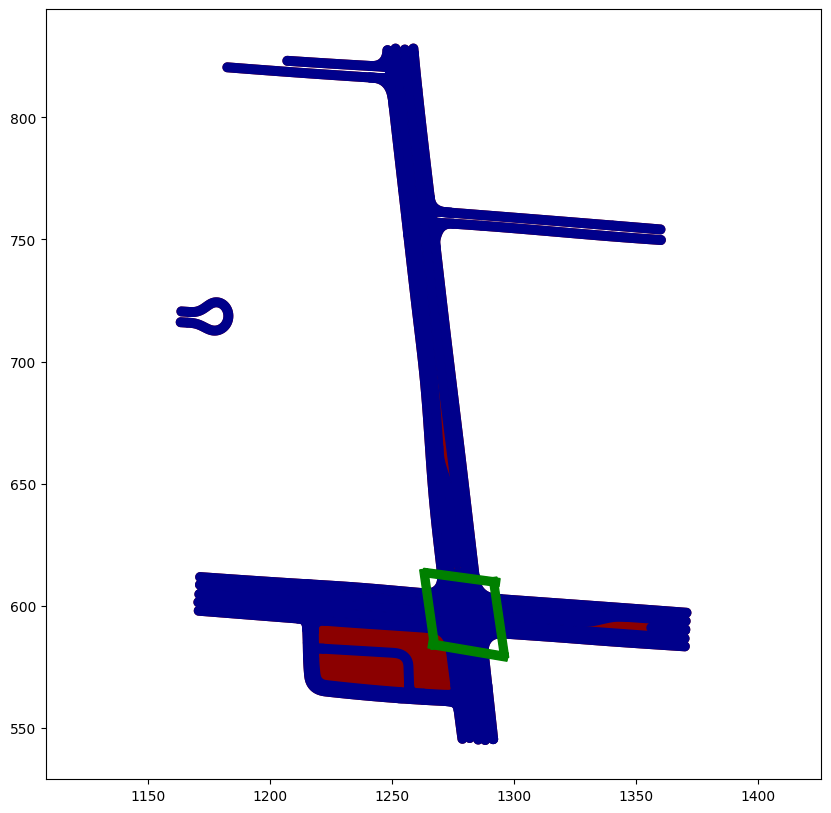

In [43]:
import matplotlib.pyplot as plt
all_bike_lane = unary_union(static_element.get_lane('bike_lane'))
all_surface_street_lane = unary_union(static_element.get_lane('surface_street'))
all_crosswalk = static_element.get_other_object('cross_walk')
fig,ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal','datalim')
# xs,ys = all_crosswalk[2].exterior.xy
# ax.fill(xs,ys,facecolor='red',alpha=0.5)
for geom in all_surface_street_lane.geoms:
    xs,ys = geom.exterior.xy
    ax.fill(xs,ys,c='darkred')


surface_street_lane = static_element.get_lane('surface_street')
for surface_street in surface_street_lane:
    xs,ys = surface_street.exterior.xy
    ax.fill(xs,ys,c='darkblue')

for crosswalk in all_crosswalk:
    xs,ys = crosswalk.exterior.xy
    ax.fill(xs,ys,c='green')



## Check interesting actor

[  0   1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18
  20  21  22  23  24  25  26  27  28  29  30  31  34  35  36  37  38  39
  40  41  42  43  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  63  64  65  66  67  68  69  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  99 100
 101 102 103 105 106]
Processing vehicle with 95 agents...


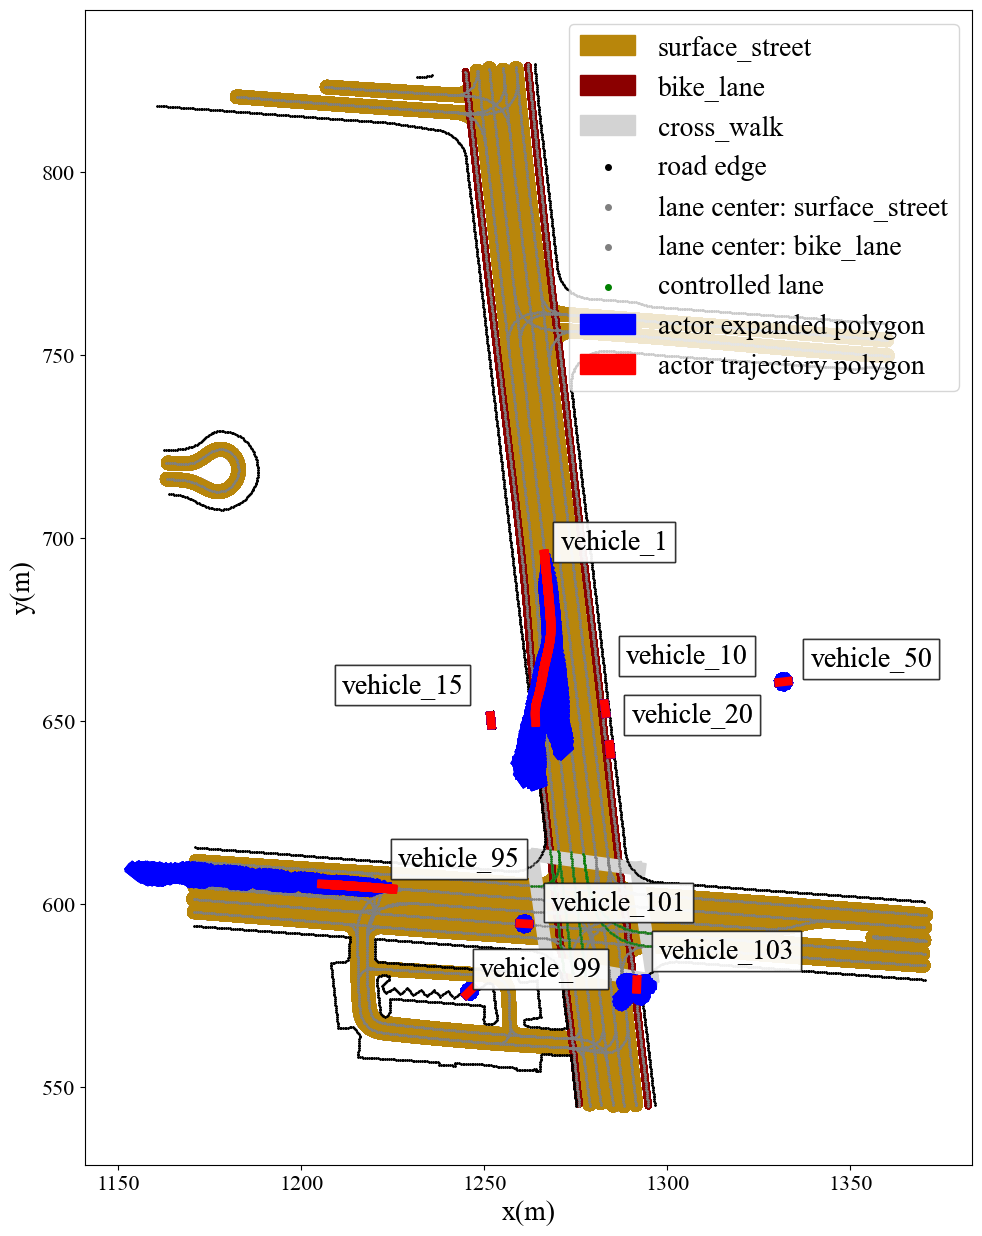

In [8]:
from create_rect_from_file import rect_object_creator,get_agent_list
from long_activity_detector import long_act_detector
import matplotlib.pyplot as plt
from data_parser import features_description
from lateral_activity_detector import lat_act_detector
from collections import OrderedDict
from helpers.diverse_plot import plot_road_lines

ROOT = os.path.abspath(os.path.dirname(" "))
ROOT = os.path.dirname(ROOT)
DATADIR = os.path.join(ROOT,"waymo_open_dataset","data","tf_example","training")
FILENUM = "00000"
FILE = f"training_tfexample.tfrecord-{FILENUM}-of-01000"
result_dict = {}

max_acc = [0,0.7,0.2,0.4,0]
a_cruise = [0,0.3,0.1,0.2,0]
delta_v = [0,1,0.2,0.5,0]

agent_state_dict = {"vehicle":{},"pedestrian":{},"cyclist":{}}
k_h=6
time_steps=91
# degree of smoothing spline
k=3
# default smoothing factor is 
smoothing_factor = time_steps / 2

t_s = 0.1
kernel = 6
sampling_threshold = 5e-3
integration_threshold = sampling_threshold*150 # 5e-3*150 = 0.75 rad. = 43 deg.
actors_activity={} # [actor_type][actor_id][validity/lo_act/la_act]
actors_static_element_relation = {} #[actor_type][actor_id][lane_type]
actors_static_element_intersection = {} #[actor_type][actor_id][lane_type][expanded/trajectory],value is a list of area of intersection

actor_dict = {"vehicle":1}
fig,ax = plt.subplots(figsize=(15,15))
font1 = {'family' : 'Times New Roman','weight' : 'normal','size':20}
lane_color = {
    'freeway':'k',
    'surface_street':'darkgoldenrod',
    'bike_lane':'darkred'
}

vehicle_list = [1,10,15,20,50,95,99,101,103]
pedestrian_list = [83,98,97,104,70]
actor_key_plot = 'vehicle'

road_graph_plot_flag = 1
for actor_type in actor_dict:
    agent_type = actor_dict[actor_type]
    agent_list = get_agent_list(agent_type,DATADIR,FILE)
    print(agent_list)
    actor_activity = {}
    actor_static_element_intersection = {}
    if len(agent_list.shape) == 0:
        agent_list = [agent_list.item()]
        print(f"Processing {actor_type} with {len(agent_list)} agents...")
    else:
        print(f"Processing {actor_type} with {agent_list.shape[0]} agents...")
    for agent in agent_list:
        if agent not in vehicle_list:
            continue
        agent_activity = {}
        agent_static_element_intersection = {}
        agent_state,_ = rect_object_creator(agent_type,agent,DATADIR,FILE)
        validity_proportion = agent_state.data_preprocessing()
        lo_act,long_v,long_v1,knots = long_act_detector(agent_state,k_h,max_acc[agent_type],t_s=0.1,a_cruise=a_cruise[agent_type],\
                                        delta_v=delta_v[agent_type],time_steps=time_steps,k_cruise=10,\
                                        k=k,smoothing_factor=smoothing_factor)
        long_v = long_v.squeeze()
        lo_act = lo_act.numpy().squeeze()
        agent_activity['validity/appearance'] = validity_proportion
        agent_activity['lo_act'] = lo_act.tolist()
        la_act,bbox_yaw_rate = lat_act_detector(agent_state,t_s,sampling_threshold,integration_threshold,k=3,smoothing_factor=smoothing_factor)
        agent_activity['la_act'] = la_act.numpy().squeeze().tolist()
        agent_key = f"{actor_type}_{agent}"
        actor_activity[f"{agent_key}_activity"] = agent_activity
        agent_state_dict[actor_type][agent_key] = agent_state
        # Generate actors in shapely
        ## computing intersection 
        actor_expanded_polygon = agent_state.expanded_polygon_set(TTC=TTC_1,sampling_fq=10)
        actor_expanded_multipolygon = agent_state.expanded_multipolygon
        actor_trajectory_polygon = agent_state.polygon_set()
        valid_start,valid_end = agent_state.get_validity_range()
        for lane_type in lane_key:
            agent_lane_intersection_expanded = np.zeros_like(lo_act).tolist()
            agent_lane_intersection_trajectory = np.zeros_like(lo_act).tolist()
            lane_polygon_set = static_element.get_lane(lane_type)
            for step in range(valid_start,valid_end+1):
                actor_expanded_multipolygon_step = actor_expanded_multipolygon[step]
                actor_trajectory_polygon_step = actor_trajectory_polygon[step]
                intersection,intersection_expanded = 0,0
                for lane_polygon in lane_polygon_set:
                    intersection_expanded += actor_expanded_multipolygon_step.intersection(lane_polygon).area
                    intersection += actor_trajectory_polygon_step.intersection(lane_polygon).area
                    x,y = lane_polygon.exterior.xy
                    if road_graph_plot_flag:
                        ax.fill(x,y,c=lane_color[lane_type],label=f'{lane_type}')
                agent_lane_intersection_expanded[step]=intersection_expanded
                agent_lane_intersection_trajectory[step]=intersection
            agent_static_element_intersection[lane_type]={
                'expanded':agent_lane_intersection_expanded,
                'trajectory':agent_lane_intersection_trajectory
            }

        for other_object_type in other_object_key:
            agent_other_object_intersection_expanded = np.zeros_like(lo_act).tolist()
            agent_other_object_intersection_trajectory = np.zeros_like(lo_act).tolist()
            other_object_polygon_list = static_element.get_other_object(other_object_type)
            for other_object_polygon in other_object_polygon_list:
                x,y = other_object_polygon.exterior.xy
                if road_graph_plot_flag:
                    ax.fill(x,y,c='lightgray',label=f'{other_object_type}')
                    _ = plot_road_lines(ax,original_data_roadgragh,original_data_light)
            for step in range(valid_start,valid_end+1):
                actor_expanded_multipolygon_step = actor_expanded_multipolygon[step]
                actor_trajectory_polygon_step = actor_trajectory_polygon[step]
                intersection,intersection_expanded = 0,0
                for other_object_polygon in other_object_polygon_list:
                    intersection_expanded += actor_expanded_multipolygon_step.intersection(other_object_polygon).area
                    intersection += actor_trajectory_polygon_step.intersection(other_object_polygon).area
                    x,y = actor_expanded_multipolygon_step.exterior.xy
                    ax.fill(x,y,c='blue',label='actor expanded polygon')
                    x,y = actor_trajectory_polygon_step.exterior.xy
                    ax.fill(x,y,c='red',label='actor trajectory polygon')
                    if step == valid_start:
                        if agent == 15:
                            xshift = -40
                            yshift = 10
                        elif agent == 104:
                            xshift = -40
                            yshift = 10
                        elif agent == 10:
                            xshift = 5
                            yshift = 10
                        else:
                            xshift = 5
                            yshift = 5
                        ax.text(x[0]+xshift,y[0]+yshift,f"{actor_type}_{agent}",fontdict=font1,bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})
                agent_other_object_intersection_expanded[step]=intersection_expanded
                agent_other_object_intersection_trajectory[step]=intersection
            agent_static_element_intersection[other_object_type]={
                'expanded':agent_other_object_intersection_expanded,
                'trajectory':agent_other_object_intersection_trajectory
            }
        actor_static_element_intersection[agent_key] = agent_static_element_intersection
        road_graph_plot_flag=0
    actors_activity[actor_type] = actor_activity
    actors_static_element_intersection[actor_type] = actor_static_element_intersection

handels,labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels,handels))

ax.set_xlabel('x(m)',fontdict=font1)
ax.set_ylabel('y(m)',fontdict=font1)
ax.tick_params(labelsize=font1['size']*0.8)
plt.xticks(fontname = "Times New Roman")
plt.yticks(fontname = "Times New Roman")
ax.set_aspect('equal')
ax.legend(by_label.values(),by_label.keys(),loc="upper right",markerscale=8.0,prop=font1)


FIGDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"figures\relation_actor_lane\v1")
plt.savefig(f"{FIGDIR}\{FILENUM}_{actor_key_plot}_with_roadgraph_1023.jpg")
plt.show()

### [test codes] plot


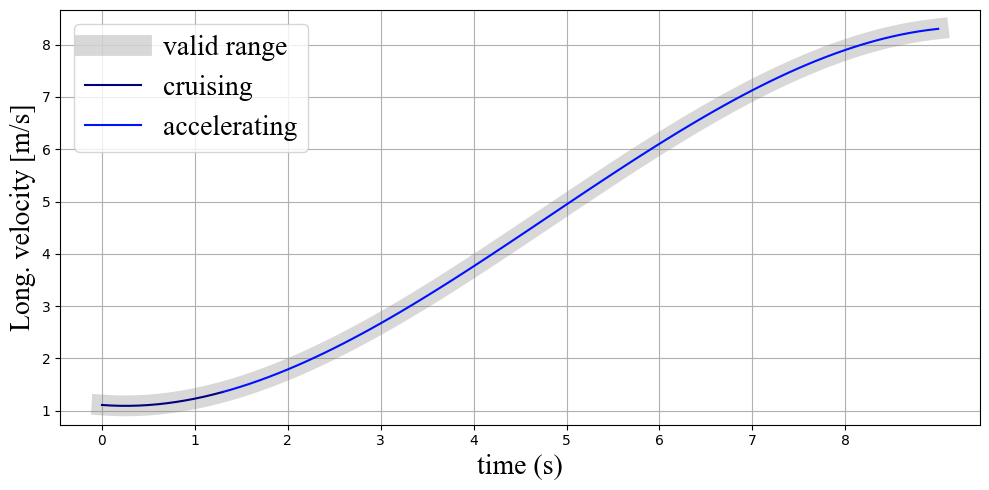

In [3]:
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from plotting_scenarios import plot_road_graph,plot_actor_activity
import matplotlib.pyplot as plt

RESULTDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"results\v4")
RESULT_TIME = f'2022-11-06-21_01'
RESULT_FILENAME = f'Waymo_{FILENUM}_{RESULT_TIME}_tag.json'
RESULT_SOLO = f'Waymo_{FILENUM}_{RESULT_TIME}_solo.json'

agent_key = 1
actors_activity = json.load(open(os.path.join(RESULTDIR,RESULT_FILENAME),'r'))['actors_activity']
solo_scenarios = json.load(open(os.path.join(RESULTDIR,RESULT_SOLO),'r'))
long_v = actors_activity['vehicle'][f'vehicle_{agent_key}_activity']['long_v']
lo_act = solo_scenarios['vehicle'][f'vehicle_{agent_key}']['lo']
valid_start,valid_end = actors_activity['vehicle'][f'vehicle_{agent_key}_activity']['valid']

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax = plot_actor_activity(long_v,lo_act,valid_start,valid_end,ax,"Long. velocity","Long. activity","Lateral")
FIGDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"figures\roadgraphs")
plt.tight_layout()
# plt.savefig(f"{FIGDIR}\{FILENUM}_roadgraphs.jpg",bbox_inches='tight')
plt.show()

### [test code] plot trajectory

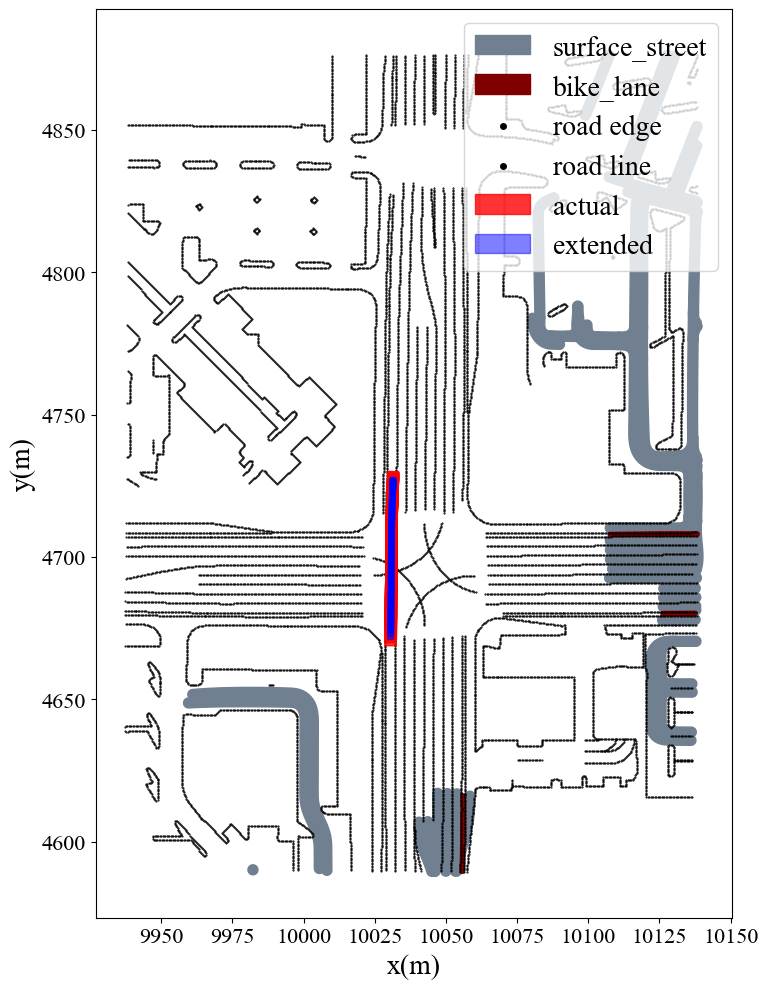

In [4]:
# imports and global setting
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import time
from rich.progress import track
import pickle
from collections import namedtuple,OrderedDict
from plotting_scenarios import plot_road_graph,plot_actor_polygons
from create_rect_from_file import rect_object_creator
from helpers.diverse_plot import create_figure_and_axes

ROOT = os.path.abspath(os.path.dirname(""))
ROOT = os.path.dirname(ROOT)
DATADIR = os.path.join(ROOT,"waymo_open_dataset","data","tf_example","training")

FILENUM = "00003"

FILE = f"training_tfexample.tfrecord-{FILENUM}-of-01000"
result_dict = {}

# parameter for estimation of the actor approaching a static element
TTC_1 = 5
# parameter for estimation of two actors' interaction
TTC_2 = 10
font1 = {'family' : 'Times New Roman','weight' : 'normal','size':20}
actor_type = 1
agent = 16
bbox_extension=2

agent_state,_ = rect_object_creator(actor_type,agent,DATADIR,FILE)
validity_proportion = agent_state.data_preprocessing()
valid_start,valid_end = agent_state.get_validity_range()
# Generate actors in shapely
actor_expanded_polygon = agent_state.expanded_polygon_set(TTC=TTC_1,sampling_fq=10)
actor_expanded_multipolygon = agent_state.expanded_multipolygon
actor_trajectory_polygon = agent_state.polygon_set()

# extended trajectory pologons
etp = agent_state.expanded_polygon_set(TTC=TTC_2,sampling_fq=10)
# generate the extended bounding boxes
ebb = agent_state.expanded_bbox_list(expand=bbox_extension)

actor_polygon = actor_trajectory_polygon
fig,ax = create_figure_and_axes(1000,1,1)
ax = plot_road_graph(DATADIR,FILE,ax=ax)
# ax = plot_actor_polygons(etp,valid_start,valid_end,ax,"actual",gradient=False,host=True)
ax = plot_actor_polygons(ebb,valid_start,valid_end,ax,"actual",gradient=False,host=True)
ax = plot_actor_polygons(actor_trajectory_polygon,valid_start,valid_end,ax,"extended",gradient=False,host=False)
handels,labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels,handels))
ax.legend(by_label.values(),by_label.keys(),loc="upper right",markerscale=8.0,prop=font1)

plt.show()


91
9


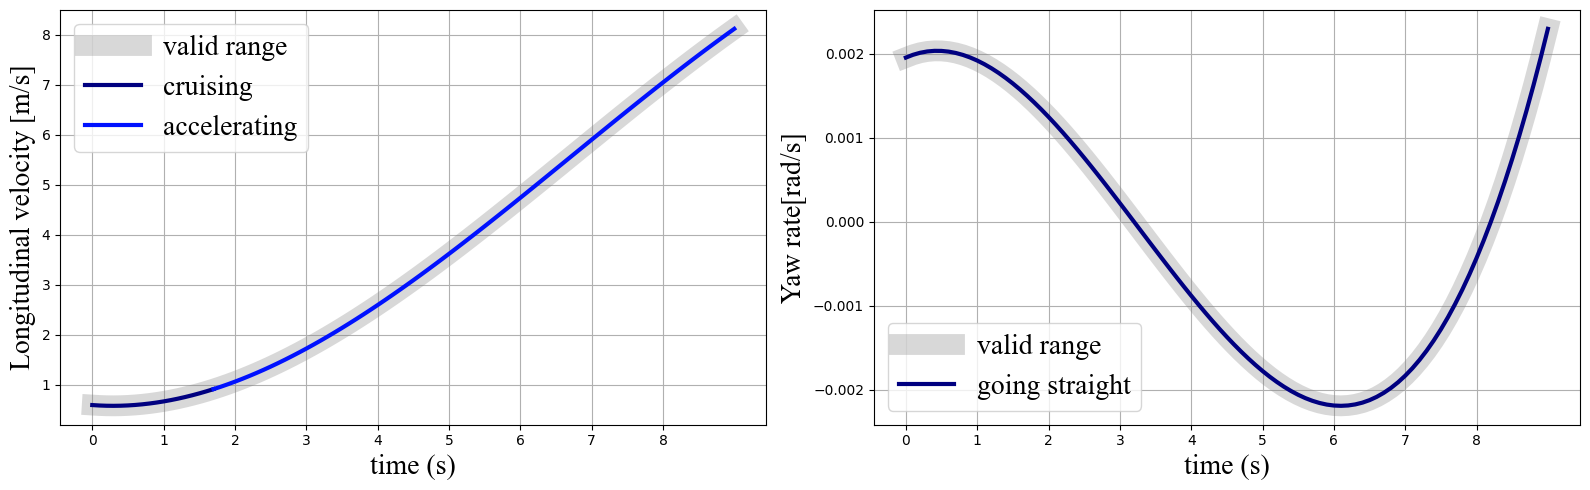

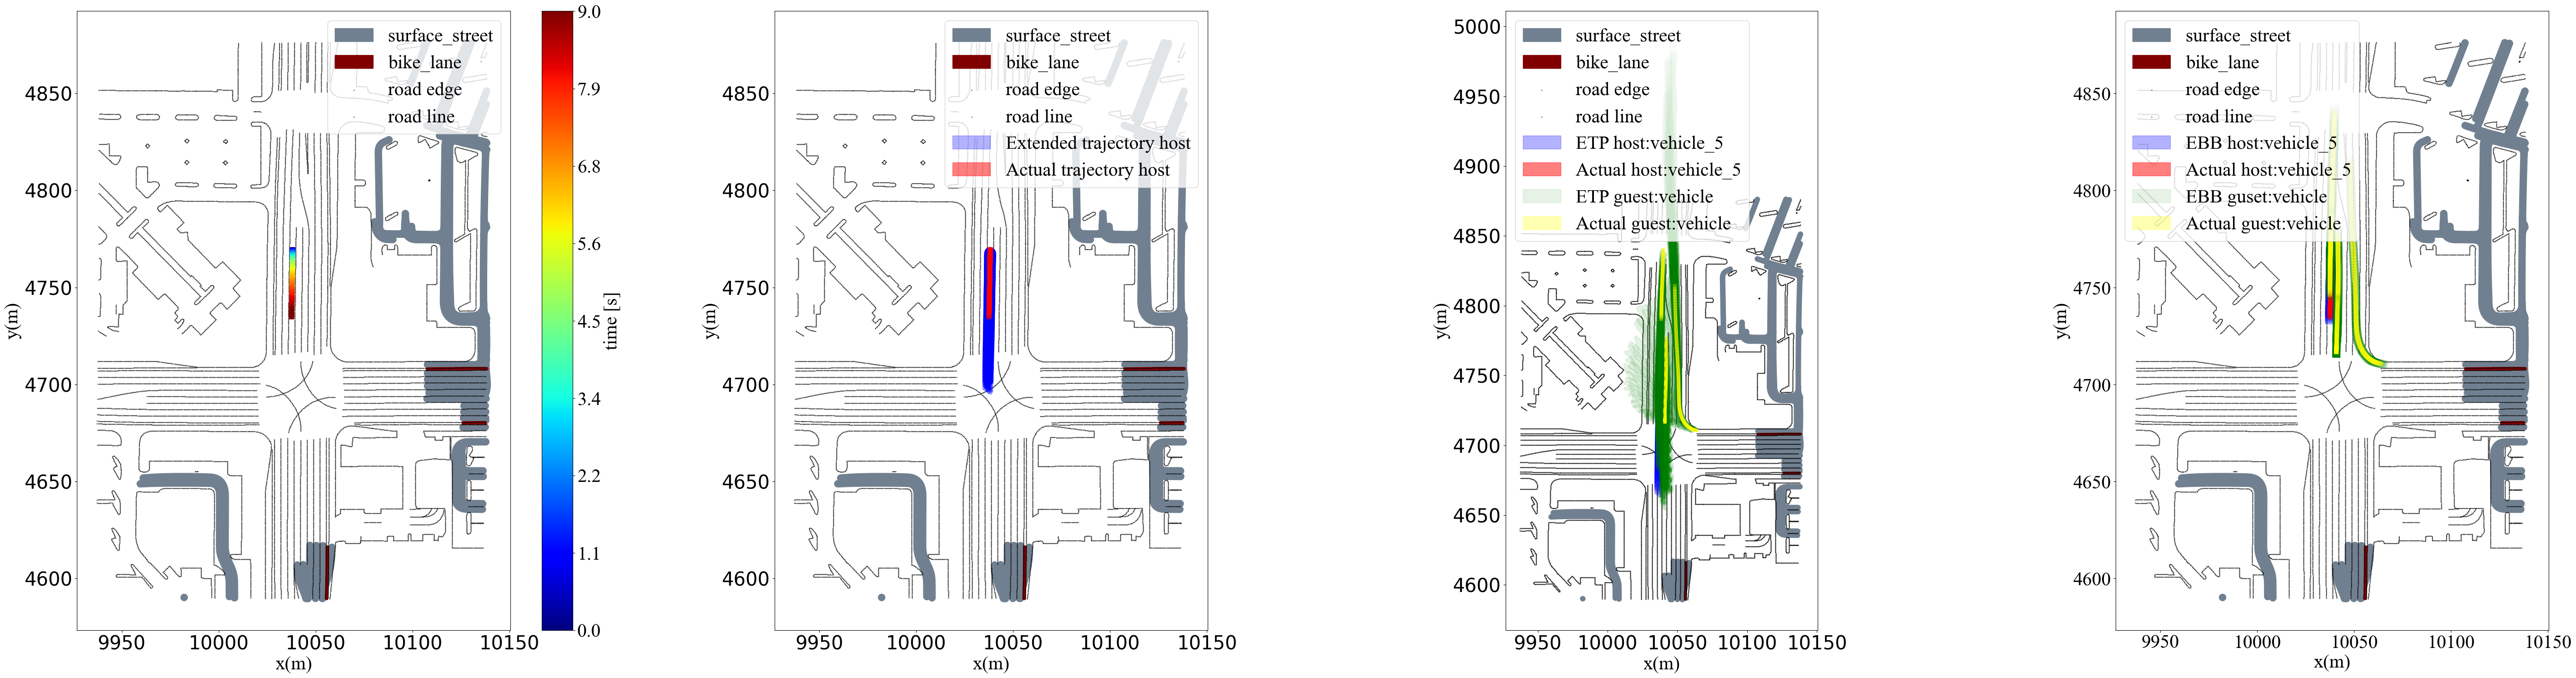

In [1]:
# imports and global setting
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import time
from rich.progress import track
import pickle
from collections import namedtuple,OrderedDict
from plotting_scenarios import plot_all_scenarios
from create_rect_from_file import rect_object_creator
from helpers.diverse_plot import create_figure_and_axes

ROOT = os.path.abspath(os.path.dirname(""))
ROOT = os.path.dirname(ROOT)
DATADIR = os.path.join(ROOT,"waymo_open_dataset","data","tf_example","training")
FIGDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"figures\scenarios\v2")
FILENUM = "00003"

FILE = f"training_tfexample.tfrecord-{FILENUM}-of-01000"

RESULTDIR = os.path.join(os.path.dirname(os.path.abspath(os.path.dirname(""))),r"results\v4")
RESULT_TIME = f'2022-11-09-09_25'
RESULT_FILENAME = f'Waymo_{FILENUM}_{RESULT_TIME}_tag.json'
RESULT_SOLO = f'Waymo_{FILENUM}_{RESULT_TIME}_solo.json'

_=plot_all_scenarios(DATADIR,FILE,FILENUM,RESULTDIR,RESULT_FILENAME,RESULT_SOLO,FIGDIR)